<h1 align="center">Hacettepe University <br> Department of Computer Science </h1> 

<h2 align="center">BBM467 - Data Intensive Applications<br>2022 Fall</h2>

<h3 align="center">Some Choices Matter, But Why?</h3>
<h3 align="left">Name    :    Murat Çelik</h3>
<h3 align="left">ID      :    21827263</h3>
<h4 align="right">Due on January 06, 2023</h4>

# Feature Selection

Feature selection is the name of the technique that aims to provide advantages in many ways by selecting a smaller subgroup from the data we have. These advantages are aspects such as increasing the success of the model, decreasing the memory area, faster training phase and obtaining a more explainable model. As a result of deepening studies with big data, it is aimed to produce faster and more successful results with fewer features.

Tam buraya kolon azaltımını gösteren bir foto hazırlamalı

Our main goal is to get a smaller feature set by eliminating irrelevant, redundant, or noisy features. For this purpose, many different methods have been considered. In this article, we will be examining different methods of feature selection on a dataset.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import LabelEncoder
from seaborn import heatmap
import xgboost as xg

Feature Selection includes many techniques. We will examine some of these with the House Prices dataset. There are numerical and categorical variables in the data with 80 columns. We will see the basic techniques in practice by examining the logic.

 We have properties related to the house at our disposal. And with these features we will try to estimate the price of the house. We will discover which features are important and which have a negative effect on us.


In [2]:
data = pd.read_csv("train.csv")
data = data.drop(["Id"],axis=1)
data.shape

(1460, 80)

In [3]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


First, we will make a house estimate with all the features. That way, we'll be able to see how much benefit we can get with each subsequent technique. Let's set some rules while making our estimation. Let's determine the missing numerical values with the mean value, and the missing categorical values with the most frequent value. Then, let's apply the encode process to use the categorical variables in our data. Then, in order to test our data, let's divide the data by 80-20%. Let's do this for each technique so we don't have any problems comparing it. The score we get is the mean squared error value.

In [4]:
def get_postprocess_data(df):
    Y = df["SalePrice"]
    df = df.drop(["SalePrice"],axis=1)
    list_numerical = df.describe().columns
    list_categorical = [x for x in (set(df.columns.tolist()) - set(list_numerical))]
    if len(list_numerical)>0:
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
        df[list_numerical] = pd.DataFrame(imp_mean.fit_transform(df[list_numerical]),columns=list_numerical)
    if len(list_categorical):
        imp_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        df[list_categorical] = pd.DataFrame(imp_frequent.fit_transform(df[list_categorical]),columns=list_categorical)
    X = pd.get_dummies(df)
    return X,Y

In [5]:
def get_score(df):
    X,Y = get_postprocess_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators = 500, learning_rate=0.1, seed = 123,verbosity = 0)
    xgb_r.fit(X_train, y_train)
    pred = xgb_r.predict(X_test)
    rmse = np.sqrt(MSE(y_test, pred))
    return rmse

It should be noted that categorical variables increase the number of columns after the encode process. For this reason, while we initially have 79 features and 1 target column, we run the model with 288 features and 1 target column.

In [6]:
X,Y = get_postprocess_data(data.copy())
X.shape

(1460, 288)

Below is the best score we got with 288 columns.

In [7]:
get_score(data.copy())

29087.212776897497

# Feature Selection Techniques
Basically, techniques are collected under 3 headings. These techniques are Wrapper techniques, Filter techniques and Embedded techniques.

## A. Wrapper Techniques

Let's start with Wrapper Methods. The main logic of this technique is to try the columns with different subsets and work with the subset that gives the best score. At the end of the day, it is the model that will give the best score and we leave the choice to the model. It takes more time than other techniques. However, it makes up for this disadvantage by being more reliable than other techniques.

We will examine 3 Wrapper techniques. The first is with the method of adding columns in each loop; the second is by column elimination method in each loop; The third is with the recursive feature elimination (RFE) technique, which removes the colon with feature evaluation.

### A1. Forward Feature Selection
You add a new feature every loop. And each loop you get a certain score. If the score is positive, you get the feature; if it is negative, you do not use the feature. The basic logic goes like this.

In [8]:
X,Y = get_postprocess_data(data.copy())
all_cols = [x for x in X.columns]
added_cols = []
best_score_add = np.inf
xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators = 500, learning_rate=0.1, seed = 123,verbosity = 0)
for x in all_cols:
    added_cols.append(x)
    X_tmp = X.copy()
    X_tmp = X_tmp[added_cols]
    X_train, X_test, y_train, y_test = train_test_split(X_tmp, Y, test_size=0.20, random_state=42)
    xgb_r.fit(X_train, y_train)
    pred = xgb_r.predict(X_test)
    loop_score = np.sqrt(MSE(y_test, pred))    
    if loop_score < best_score_add:
        best_score_add = loop_score
        continue
    added_cols.remove(x)

In [9]:
print(added_cols)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MiscVal', 'MSZoning_C (all)', 'MSZoning_FV', 'Alley_Grvl', 'LandSlope_Mod', 'Neighborhood_NWAmes', 'HouseStyle_2.5Unf', 'BsmtFinType2_LwQ']


In [10]:
print(len(added_cols))

30


As a result, using the columns above, we get the following score. As a result, we achieve 17% more success with 31 columns. The only loss we have is that we have to wait for a longer training period for this procedure.

In [11]:
best_score_add

24147.160065036278

### A2. Backward Feature Selection
This method works in the opposite way of the previous method. We start the training with all the columns and remove the colon in order, if the result is positive, the colon is the most suitable option.

In [12]:
X,Y = get_postprocess_data(data.copy())
all_cols = [x for x in X.columns]
remove_cols = []
best_score_remove = get_score(data.copy())
xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators = 500, learning_rate=0.1, seed = 123,verbosity = 0)
for x in all_cols:
    remove_cols.append(x)
    X_tmp = X.copy()
    X_tmp = X_tmp.drop(remove_cols,axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_tmp, Y, test_size=0.20, random_state=42)
    xgb_r.fit(X_train, y_train)
    pred = xgb_r.predict(X_test)
    loop_score = np.sqrt(MSE(y_test, pred))  
    if loop_score <= best_score_remove:
        best_score_remove = loop_score
        continue
    remove_cols.remove(x)

In [13]:
print(remove_cols)

['OverallQual', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'BsmtHalfBath', 'GarageYrBlt', 'MSZoning_RH', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl', 'LotShape_IR2', 'LotShape_IR3', 'Utilities_AllPub', 'Utilities_NoSeWa', 'LandSlope_Gtl', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_IDOTRR', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_Timber', 'Condition1_Feedr', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_PosA', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_SFoyer', 'RoofStyle_Flat', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1s

In [14]:
print(len(remove_cols))

105


Score success has increased by 18%. The number of columns removed is also x. We can see that these techniques produce successful results. They can be preferred for successful results for projects that do not have time constraints.

In [15]:
best_score_remove

23634.360693001116

### A3. Recursive Feature Elimination (RFE)
The data is trained with different feature sets. The least valuable columns are cut off and the best columns are output. While doing this, the function takes an ML model and performs its operation with it. In this way, it also takes into account which features the model focuses on.

In [16]:
from sklearn.feature_selection import RFE
X,Y = get_postprocess_data(data.copy())
xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators = 500, learning_rate=0.1, seed = 123,verbosity = 0)
selector = RFE(xgb_r, n_features_to_select=100, step=1)
selector = selector.fit(X,Y)
cols_added = []
for k,v in zip(X_train.columns,selector.support_):
    if v:
        cols_added.append(k)
cols_added = [x for x in set(cols_added)]
X,Y = get_postprocess_data(data.copy())
X = X[cols_added]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators = 500, learning_rate=0.1, seed = 123,verbosity = 0)
xgb_r.fit(X_train, y_train)
pred = xgb_r.predict(X_test)
best_score_rfe = np.sqrt(MSE(y_test, pred))

In [17]:
print(cols_added)

['Fence_MnPrv', 'LotArea', 'Neighborhood_Edwards', 'Exterior1st_Plywood', 'MSZoning_FV', 'LandContour_Bnk', 'GrLivArea', 'HalfBath', 'Exterior1st_WdShing', 'Exterior1st_MetalSd', 'Exterior2nd_Stucco', 'Fence_GdWo', 'LotFrontage', 'YearRemodAdd', 'LandContour_Low', 'BedroomAbvGr', 'MSZoning_RL', 'WoodDeckSF', 'GarageArea', 'LandContour_HLS', 'GarageType_Attchd', 'PavedDrive_N', 'LotShape_Reg', 'ScreenPorch', 'MiscVal', 'Condition2_PosN', 'Exterior2nd_VinylSd', 'TotalBsmtSF', 'YearBuilt', 'OverallCond', 'LowQualFinSF', 'Neighborhood_Crawfor', 'EnclosedPorch', 'MoSold', 'BsmtFullBath', 'OpenPorchSF', 'Condition1_PosA', 'Condition1_RRAe', 'HeatingQC_Gd', 'Electrical_SBrkr', 'Heating_OthW', '3SsnPorch', 'Heating_Grav', 'HouseStyle_2.5Fin', 'YrSold', 'Condition2_Norm', 'BsmtFinType2_Unf', 'RoofStyle_Gable', 'LotConfig_Corner', 'GarageQual_Gd', 'Alley_Pave', 'TotRmsAbvGrd', 'Fireplaces', 'Neighborhood_MeadowV', 'HouseStyle_SLvl', 'MSZoning_C (all)', 'GarageCond_TA', 'BsmtUnfSF', 'Neighborhood

In [18]:
print(len((cols_added)))

76


Success increased by 9%. In addition, it is seen that an effective result is obtained by using only 76 columns. However, this is the algorithm that takes the most time compared to other algorithms.

In [19]:
best_score_rfe

26727.995926667612

## B. Filter Techniques

Filter techniques are based on statistical analysis. It is advantageous in terms of computation time because it is independent of the model. It determines the relationships between the features by comparing the features with each other and with the target. If these relationships benefit the score, they stay, if they don't, they leave. The main purpose is in this direction.

### B1. More than 30% missing data

Missing data is filled according to certain techniques. But filling techniques should be determined in accordance with the majority. The large number of missing data will not benefit the model, but may also harm it. For this reason, any feature with more than 30% missing data is removed. In this way, the score is also improved and the number of colons is reduced.

In [20]:
len_data = len(data)
drop_cols = []
for k,v in data.isnull().sum().items():
    if v/len_data > 3/10:
        drop_cols.append(k)
print(f"Number of features with more than 30% missing data : {len(drop_cols)} feature")
data_tmp = data.drop(drop_cols,axis=1)
get_score(data_tmp.copy())

Number of features with more than 30% missing data : 5 feature


29336.772989319637

### B2. Pearson Correlation

Pearson Correlation is a technique that explains the relationship between two different features. Values between -1 and 1 are taken. The value of 1 is both positive and correlated. A value of -1 indicates that one of the two values is increasing while the other is decreasing, which has the opposite correlation. 0 indicates that there is no connection between them. Here we have two different methods.

1) The target data (SalePrice) and the connection of each feature are checked. If these values are independent of each other, we can say that that feature is of no use to us.

2) We compare the features among each other. If there are features with strong relationships, we can state that perhaps one of these features is unnecessary. Or if there is a relatively strong connection, maybe we can use those two values to reveal a single feature. Generally, instead of two separate properties for mass and height, a single property "body mass index" can be used.

We have the chance to understand all these with the correlation technique.

Note: This technique is only valid for numeric values.

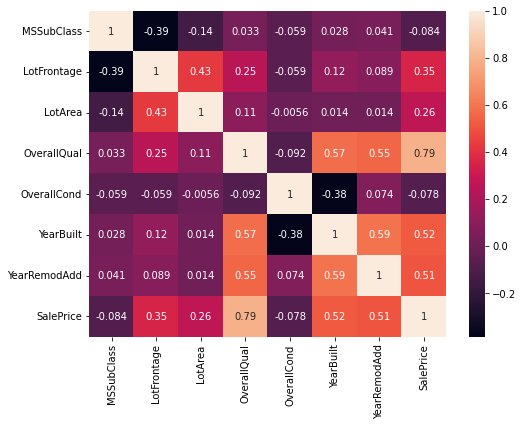

In [21]:
cols1 = ['MSSubClass', 'LotFrontage', 'LotArea','OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', "SalePrice"]
plt.figure(figsize = (8,6))
ax = heatmap(data[cols1].corr(method="pearson"),annot=True,)
plt.show()

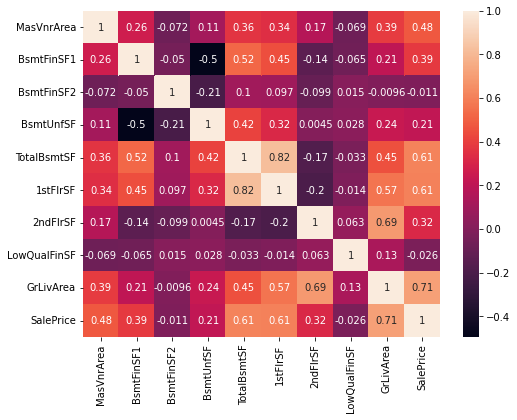

In [22]:
cols2 = ['MasVnrArea','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
         '1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea',"SalePrice"]
plt.figure(figsize = (8,6))
ax = heatmap(data[cols2].corr(method="pearson"),annot=True,)
plt.show()

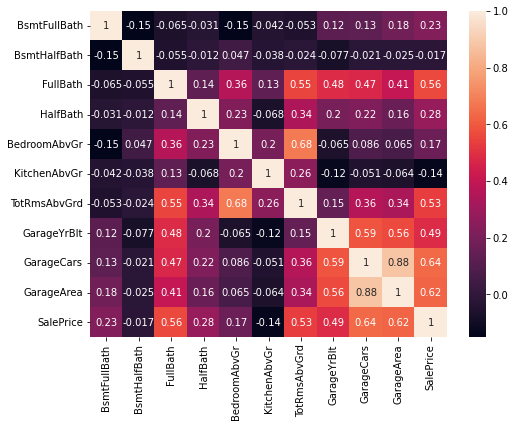

In [23]:
cols3 = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 
         'GarageCars', 'GarageArea',"SalePrice"]
plt.figure(figsize = (8,6))
ax = heatmap(data[cols3].corr(method="pearson"),annot=True,)
plt.show()

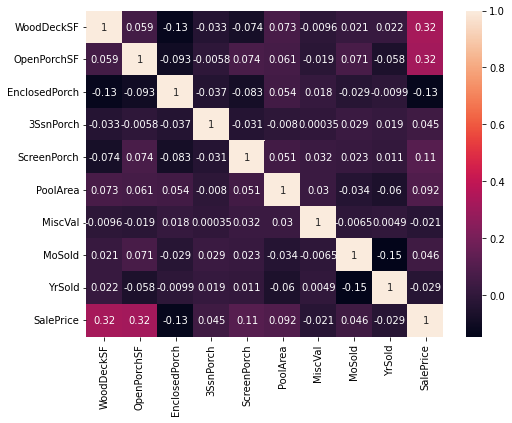

In [24]:
cols4 = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
         'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',"SalePrice"]
plt.figure(figsize = (8,6))
ax = heatmap(data[cols4].corr(method="pearson"),annot=True,)
plt.show()

We want to remove those columns if their relation to SalePrice is less than an absolute value of 0.1. In this way, we go to the reduction of the number of columns.

In [25]:
remove_cols = ["3SsnPorch","PoolArea","MiscVal","MoSold","YrSold","BsmtHalfBath", "BsmtFinSF2","LowQualFinSF","MSSubClass","OverallCond"]

In [26]:
data_tmp = data.copy()
data_tmp = data_tmp.drop(remove_cols,axis=1)
get_score(data_tmp)

29504.837161778643

### B3. Mutual information (MI)

The Mutual Information technique is based on a simple rule. It is the determination of the probabilistic relationship of two numerical data with each other. The scoring of 50 columns is shown below. It is aimed to score points by trying these 50 features in the model.

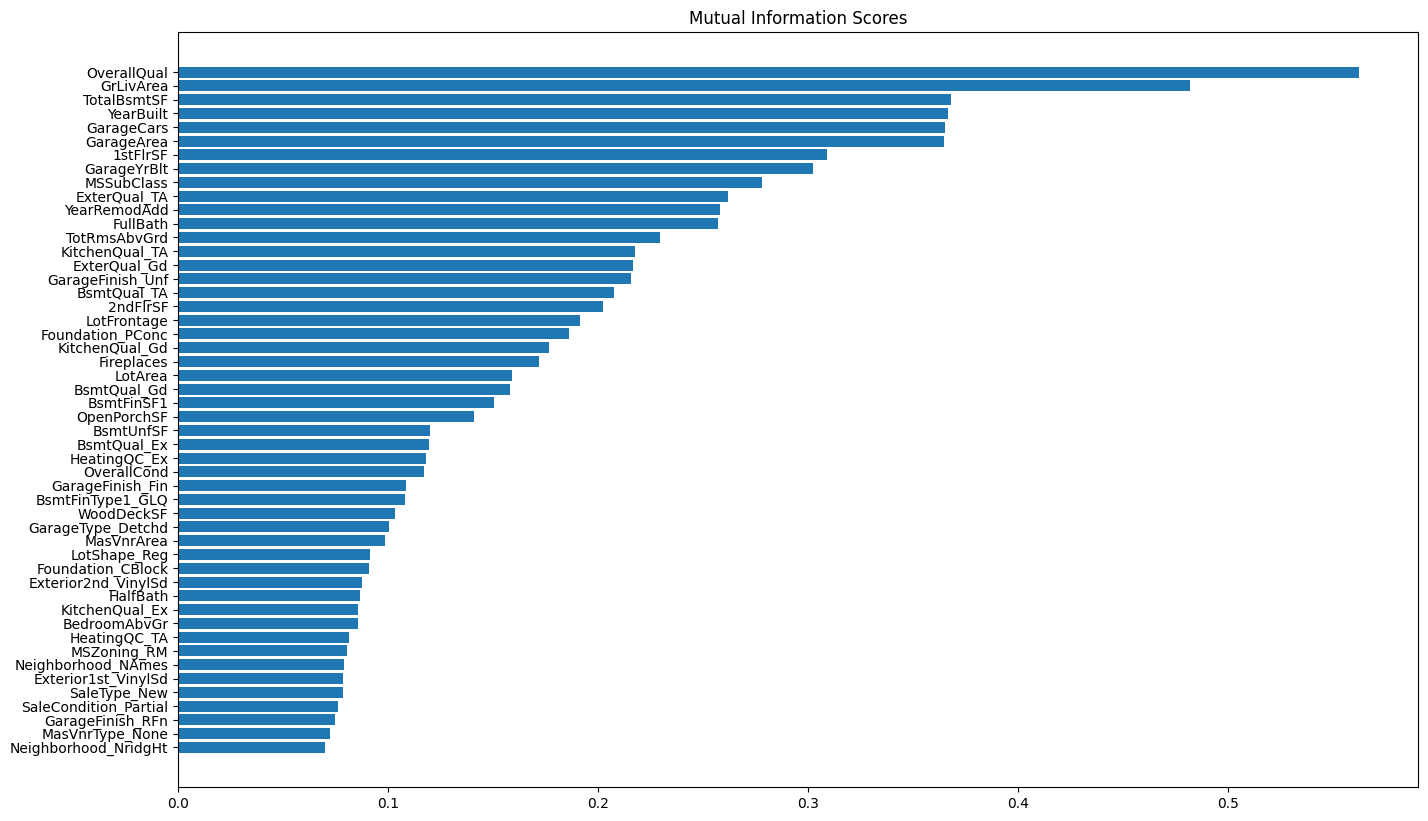

In [27]:
from sklearn.feature_selection import mutual_info_regression

X,Y = get_postprocess_data(data.copy())
list_numerical = data.describe().columns
list_categorical = [x for x in (set(X.columns.tolist()) - set(list_numerical))]

def mutual_info(X, y, discrete_features):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    
    mutual_info_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mutual_info_scores = pd.Series(mutual_info_scores, name="MI Scores", index=X.columns)
    mutual_info_scores = mutual_info_scores.sort_values(ascending=False)
    return mutual_info_scores

mutual_info_scores = mutual_info(X, Y, list_categorical)

def plot_mutual_info_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(16, 10))
plot_mutual_info_scores(mutual_info_scores[:50])

In [28]:
X,Y = get_postprocess_data(data.copy())
X = X[list(mutual_info_scores[:50].keys())]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators = 500, learning_rate=0.1, seed = 123,verbosity = 0)
xgb_r.fit(X_train, y_train)
pred = xgb_r.predict(X_test)
rmse = np.sqrt(MSE(y_test, pred))

*While* increasing the success rate by 9% with this technique, we were able to achieve results with only 50 features.

In [29]:
rmse

27325.001348547186

#### F - Statistic
It is a technique that calculates the values of the features with F-statistic and p-values calculations. With this technique, we reduce the number of columns up to 50.

In [30]:
from sklearn.feature_selection import SelectKBest, f_regression
def select_best_features(df,num_features,type_filter):
    Y = df["SalePrice"]
    df = df.drop(["SalePrice"],axis=1)
    list_numerical = df.describe().columns
    list_categorical = [x for x in (set(df.columns.tolist()) - set(list_numerical))]
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    df[list_numerical] = pd.DataFrame(imp_mean.fit_transform(df[list_numerical]),columns=list_numerical)
    imp_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    df[list_categorical] = pd.DataFrame(imp_frequent.fit_transform(df[list_categorical]),columns=list_categorical)
    X = pd.get_dummies(df)
    _filter = SelectKBest(type_filter, k=num_features)
    _filter.fit(X, Y)
    added_features = []
    filter_bool = _filter.get_support()
    features = X.columns
    for x in features[filter_bool]:
        added_features.append(x)
    added_features = [x for x in set(added_features)]
    return added_features

In [31]:
cols = select_best_features(data,50,f_regression)

In [32]:
print(cols)

['LotArea', 'GrLivArea', 'HalfBath', 'Exterior1st_VinylSd', 'BsmtFinSF1', 'LotFrontage', 'ExterQual_Ex', 'YearRemodAdd', 'WoodDeckSF', 'GarageArea', 'LotShape_Reg', 'HeatingQC_Ex', 'GarageYrBlt', 'ExterQual_Gd', 'GarageCars', 'Exterior2nd_VinylSd', 'BsmtFinType1_GLQ', 'TotalBsmtSF', 'YearBuilt', 'KitchenQual_Gd', 'OpenPorchSF', 'GarageFinish_Fin', 'SaleCondition_Partial', 'GarageType_Detchd', '2ndFlrSF', 'BsmtQual_TA', 'ExterQual_TA', 'MasVnrType_Stone', 'Foundation_PConc', 'HeatingQC_TA', 'KitchenQual_TA', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu_Ex', 'Neighborhood_NridgHt', 'BsmtQual_Ex', 'GarageFinish_Unf', 'SaleType_New', 'FullBath', 'MasVnrArea', 'BsmtExposure_No', 'CentralAir_Y', 'KitchenQual_Ex', 'OverallQual', 'BsmtExposure_Gd', '1stFlrSF', 'Neighborhood_NoRidge', 'MasVnrType_None', 'Foundation_CBlock', 'MSZoning_RM']


In [33]:
print(len(cols))

50


We achieve 11% success with 50 features.

In [34]:
X,Y = get_postprocess_data(data.copy())
X = X[cols]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators = 500, learning_rate=0.1, seed = 123,verbosity = 0)
xgb_r.fit(X_train, y_train)
#print(X.shape)
pred = xgb_r.predict(X_test)
rmse = np.sqrt(MSE(y_test, pred))
rmse

27089.779869904323

### B4. Chi squred
We calculate the chi-square statistics between the non-negative features and the class. In this way, we reduce our data.

In [35]:
from sklearn.feature_selection import SelectKBest,chi2
cols = select_best_features(data,100,chi2)

We lost 8% success with this technique. However, we achieved this score with less data by discarding 55% of our column count.

In [36]:
X,Y = get_postprocess_data(data.copy())
X = X[cols]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators = 500, learning_rate=0.1, seed = 123,verbosity = 0)
xgb_r.fit(X_train, y_train)
pred = xgb_r.predict(X_test)
rmse = np.sqrt(MSE(y_test, pred))
rmse

31245.346215045553

## C. Embedded Techniques

Models like RandomForest have their own structure to sort features. Here we select features by relying on the decision mechanism of a direct model.

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [38]:
df =data.copy()
Y = df["SalePrice"]
df = df.drop(["SalePrice"],axis=1)
list_numerical = df.describe().columns
list_categorical = [x for x in (set(df.columns.tolist()) - set(list_numerical))]
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df[list_numerical] = pd.DataFrame(imp_mean.fit_transform(df[list_numerical]),columns=list_numerical)
imp_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df[list_categorical] = pd.DataFrame(imp_frequent.fit_transform(df[list_categorical]),columns=list_categorical)
X = pd.get_dummies(df)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [39]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 100,random_state=42))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(random_state=42))

In [40]:
selected_feat= X.columns[(sel.get_support())]
len(selected_feat)

21

In [41]:
print(selected_feat)

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'BsmtQual_Ex',
       'GarageFinish_Unf'],
      dtype='object')


We see that we can achieve the same score with only 21 columns out of 288 columns. Although this does not actually benefit us as a success, it shows once again the importance of feature selection for saving computation time and space.

In [42]:
X,Y = get_postprocess_data(data.copy())
X = X[selected_feat]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators = 500, learning_rate=0.1, seed = 123,verbosity = 0)
xgb_r.fit(X_train, y_train)
pred = xgb_r.predict(X_test)
rmse = np.sqrt(MSE(y_test, pred))
rmse

30572.39240026376

## Conclusion

We tried hands-on techniques of feature selection together. We have covered its general usage and logic. We have seen how much these techniques will contribute in the project phase.

 With big data, we should continue to look for ways to solve the increasing problems more efficiently. Feature selection is just one of those titles. With the techniques we use under many different headings, we can develop our project in every aspect and present it successfully.

Personal note: The techniques in this article are those that were also asked in the interview. Knowing the importance and goals of feature selection may be the information that opens the door to a good company.

## References

1. https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection
2. https://www.kaggle.com/c/house-prices-advanced-regression-techniques
 